In [2]:
## imports
#%matplotlib qt


import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path
from scipy import integrate

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Read and plot GW data

In [3]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [4]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0][0]
    TUpIndex = np.where(time >= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def CutTimesArray(time, Arr, TLow, TUp): 
    TLowIndex = np.where(time <= TLow)[0] 
    if(len(TLowIndex) > 0):
        TLowIndex = TLowIndex[-1]
    else:
        TLowIndex = 0
    TUpIndex = np.where(time >= TUp)[0]
    if(len(TUpIndex) > 0):
        TUpIndex = TUpIndex[0]
    else:
        TUpIndex = -1
        
    time = time[TLowIndex:TUpIndex]
    Ans = []
    for data in Arr:
        Ans.append(data[TLowIndex:TUpIndex])
    return time, Ans 


def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

In [5]:
## Plot strain at various radii

def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
#PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev2/')

## Read in horizon data 

In [6]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/HeadOn_Harmonic/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
    return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
def distance_to_horizon(time, xx, yy, zz):
    """ time, x,x yy, zz are scalars for the position"""
    if time <= t_merger:
        min_dist = 1e10
        for horizon in ["A", "B"]:
            """ Have to minimize over AhA and AhB distances"""
            xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
        return sqrt(min_dist)
    elif time > t_merger:
        xx_h, yy_h, zz_h = horizon_at_time(time, "C")
        dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
        return sqrt(dist)
    else:
        print("somehow here")
        print(time, t_merger, t_ringdown)
                
def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        dist_horizon = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)

    return(sqrt(min_distance))
            

## Read in geodesics trajectories

In [7]:
## Read geodesic trajectories from Node0.h5 and dump to .dat files

def ReadGeodesicData(p, t_start, t_end):
    """ Read in an array of times and positions for all geodesics at once, 
        and return the trajectories indexed by geodesic """
        
    def AppendGeodesicsTime(Lev, Run):

        print("Reading Geodesic data for " + Lev + " and " + Run)

        file = p + '/' + Lev + '/' + Run + '/Run/Node0.h5'
        f = h5py.File(file, 'r')
        ## grab the .dat files
        keys = [k for k in f.keys() if 'dat' in k]
        ## Array of times from the .dat files
        times = [float(k.split('.dat')[0]) for k in keys]
        ## sort keys according to times
        times, keys = zip(*sorted(zip(times, keys)))
        # grab the number of geodesics
        N_geodesics = len(f[keys[-1]][:,0])
        print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
        ## Minimum index
        m = int(f[keys[-1]][:,0][0])
        print("Geodesic index offset of this refinement iteration: ", m)
    
        X = [ [] for _ in range(N_geodesics)]
        Y = [ [] for _ in range(N_geodesics)]
        Z = [ [] for _ in range(N_geodesics)]
        L = [ [] for _ in range(N_geodesics)]
        T = [ [] for _ in range(N_geodesics)]
    
        for k, t in zip(keys, times):
            print(t)
            if ((t > t_start) and (t < t_end)):
                print("%.1f  " % t, end = '')
                data = f[k]
                ## indices and positions for all geodesics at this time
                indices = data[:,0]
                l = data[:,1]
                x = data[:,5]
                y = data[:,6]
                z = data[:,7]
                ## fill in the array for each index
                for i, j in zip(indices.astype(int), range(len(indices))):
                    X[i-m] = np.append(X[i-m], x[j])
                    Y[i-m] = np.append(Y[i-m], y[j])
                    Z[i-m] = np.append(Z[i-m], z[j])
                    L[i-m] = np.append(L[i-m], l[j])
                    T[i-m] = np.append(T[i-m], t)

        print("\n")
        ## Once we have the arrays constructed, append them to the file
        print('Read the geodesic data, now writing the files')
        print("Masha", len(T))
        for a in range(len(T)):
            ##if (len(T[a]) > 1):
                ## Remember to add in the minimum index since the starting 
                ## geodesic index just gets incremented during reach refinement
                ## level (by the number of geodesics that came from the levels before)
            ff = open(p + '/Trajectories/' + str(a + m) + '.dat','ab')
            np.savetxt(ff, np.c_[T[a],X[a],Y[a],Z[a],L[a]])
            ff.close()
        print('Finished writing the files')
            
    ## Go through the refinement levels and the segments
    RefinementLevs = [el for el in os.listdir(p) if "Lev" in el]
    print("RefinementLevs:", RefinementLevs)
    for lev in RefinementLevs:
        ### MASHA remember to do the offset! -- with min index
        Segments = os.listdir(p + '/' + lev)
        print(lev + " Segments:", Segments)
        for segment in Segments:
            AppendGeodesicsTime(lev, segment)

def MakeGeodesicDatFiles(p, t_start, t_end):
    """ Print the result of ReadGeodesicData to files """
    ReadGeodesicData(p, t_start, t_end)

## Functions for reading GetTrajectoriesFromH5 output
def GetGeodesicTrajectory(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + 'Trajectories/' + str(n) + '.dat'
    #t, x, y, z, lapse = np.loadtxt(f, comments="#",usecols=([0,5,6,7,1]),unpack=True)
    t, x, y, z, lapse = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4]),unpack=True)
    return t, x, y, z, lapse

def GetGeodesicIndices(p):
    """ Return the indices of all of the geodesics we have printed to file """
    Files = os.listdir(p + '/Trajectories')
    Indices = [int(file.split('.dat')[0]) for file in Files]
    Indices = sorted(Indices)
    return Indices

In [8]:
##MakeGeodesicDatFiles('Data/TraceHeadOn_0_0_100_150', -1, 1000)

## Zero crossings computations

In [9]:
## Zero crossings computations
def ComputeZeroCrossings(p, n):
    """ Compute the number of zero crossings in the y-z plane - 
        useful for head-on runs where the collision happens
        along the x axis """
    t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
    theta = np.arctan2(z, y)
    zero_crossings = len(np.where(np.diff(np.sign(theta)))[0])
    return zero_crossings

def MakeZeroCrossingsFile(p):
    """ Make a file with the format [geodesic index, number of zero crossings] so 
        that we only have to compute the number of zero crossings once """
    ns = GetGeodesicIndices(p)
    crossings = [ComputeZeroCrossings(p, n) for n in ns]
    np.savetxt(p + 'ZeroCrossings.dat', np.c_[ns, crossings], fmt = '%d %d')
    
def GetGeodesicsZeroCrossingsIndices(p, N):
    """ Return the indices of the geodesics that make N zero-crossings """
    f = p + 'ZeroCrossings.dat'
    ns, zero_crossings = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True,dtype=int)
    indices = ns[np.where(zero_crossings == N)[0]]
    return indices
    

In [10]:
##MakeZeroCrossingsFile('Data/TraceHeadOn_0_0_100_319.7/')
#GetGeodesicsZeroCrossingsIndices('Data/TraceHeadOn_0_0_100_319.7/', 3)

## Plot geodesic trajectories

In [31]:
## Plot geodesic trajectories
def PlotGetTrajectoriesFromH5(p_arr):
    
    def plot_trajectories_file(p, color):
        
        #Indices = GetGeodesicIndices(p)[0:1]
        Indices = GetGeodesicsZeroCrossingsIndices(p, 4)
        #Indices = [12237]
        Indices = [38103]
        #print(Indices)
        
        #cmap = matplotlib.cm.get_cmap('jet')
        #colors = [cmap(float(i)/len(Indices)) for i in range(len(Indices))][::-1]
        #for n, color in zip(Indices, colors):
        for n in Indices:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            #t, Arr = CutTimesArray(t, [x, y, z, lapse], 100, 340)
            #x, y, z, lapse = Arr
            ax.plot(x, y, z, lw = 1.0, label = n) #, color = color)
            #ss = ax.scatter(x, y, z, s=20, c=lapse, cmap = 'rainbow', vmin=0, vmax=12)
            #skip = 2
            #for tt, xx, yy, zz in zip(t[::skip], x[::skip], y[::skip], z[::skip]):
            #    ax.text(xx, yy, zz, str(tt))
        #cbar = fig.colorbar(ss, fraction=0.03, pad=0.04,  orientation="horizontal")
        #cbar.set_label(r'$\log \alpha p_0$', rotation=0)
                
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    #Add in the horizons
#     for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
#         t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
#         #t_h, x_h, y_h, z_h, temp = CutTimesGeodesic(t_h, x_h, y_h, z_h, z_h, 155, 180)
#         plt.plot(x_h, y_h, z_h, color='black', lw = 2.0)
        
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_trajectories_file(p, cs[i])
        
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    
    #lim = 1.0
    #ax.set_xlim(-lim, lim)
    #ax.set_ylim(-lim, lim)
    #ax.set_zlim(-lim, lim)
    
    ax.set_axis_off()

    plt.legend()
    plt.tight_layout()
    plt.show()
    


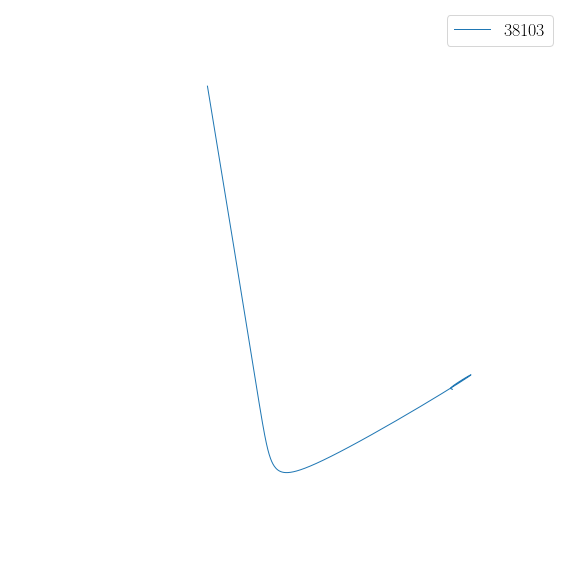

In [32]:
PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_0_0_100_150/'])

## Frenet-Serret Analysis

### Given the trajectories {x(t), y(t), z(t)}, let's compute the Frenet-Serret frame

In [12]:
## Compute quantities for Frenet-Serret Analysis
def ComputeArcLength(t, x, y, z):
    """ For a given trajectory {x(t), y(t), z(t)}, compute and return
        the arclength s(t) as a function of time"""
    dx = np.gradient(x, t)
    dy = np.gradient(y, t)
    dz = np.gradient(z, t)

    ## Compute the magnitude
    mag = np.sqrt(dx**2 + dy**2 + dz**2)
    
    ## Take a running integral 
    s = integrate.cumtrapz(mag, t, initial = 0.0)
    
    ## check that s(t) is monotonically increasing
    check = np.where((s[1:] - s[:-1]) <= 0.0)[0]
    if len(check) > 0:
        print("s(t) is non-monotonically increasing!")
        
    return s

def ComputeFrenetSerretTNB(t, x, y, z):
    s = ComputeArcLength(t, x, y, z)
    
    T_x = np.gradient(x, s)
    T_y = np.gradient(y, s)
    T_z = np.gradient(z, s)
    
    Tmag = np.sqrt(T_x**2 + T_y**2 + T_z**2)
    print(np.min(Tmag), np.max(Tmag))
    
    T_x = T_x / Tmag
    T_y = T_y / Tmag
    T_z = T_z / Tmag

    dTds_x = np.gradient(T_x, s)
    dTds_y = np.gradient(T_y, s)
    dTds_z = np.gradient(T_z, s)
    
    dTds_mag = np.sqrt(dTds_x**2 + dTds_y**2 + dTds_z**2)
    
    N_x = dTds_x / dTds_mag
    N_y = dTds_y / dTds_mag
    N_z = dTds_z / dTds_mag
    
    #Nmag = np.sqrt(N_x**2 + N_y**2 + N_z**2)
    
    B_x = T_y * N_z - T_z * N_y
    B_y = - T_x * N_z + T_z * N_x
    B_z = T_x * N_y - T_y * N_x
    
    #Bmag = np.sqrt(B_x**2 + B_y**2 + B_z**2)
    
    kappa = dTds_mag ## curvature

    return kappa
    #return T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z, kappa
    
    

In [70]:
def ArcLengthNoise(p, n):
    """ Explorations in noise due to the arclength s(t) parameter """
    
    t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
    s = ComputeArcLength(t, x, y, z)

    plt.figure(figsize=(10,8))

    T = np.gradient(x, s)
    plt.plot(t, s, '-', label='s(t)',markersize=mm)
    plt.plot(t, np.gradient(s, t), '-', label='ds/dt',markersize=mm)

    kappa = ComputeFrenetSerretTNB(t, x, y, z)
    plt.plot(t, kappa, '-o', label='kappa', markersize=mm)
    
    plt.xlabel('t')
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


0.9997270247218877 1.0002659851383913


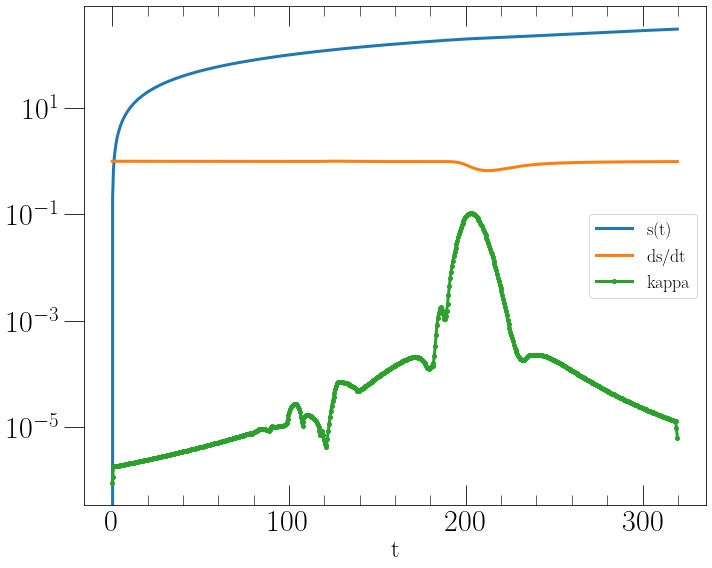

In [71]:
p = '/Users/mokounkova/TracingMerger/Data/TraceHeadOn_0_0_100_500/'
p = '/Users/mokounkova/TracingMerger/Data/TraceHeadOn_0_0_100_319.7_Horizon/'
#for n in [2000, 9000, 18000, 40000]:
#    ArcLengthNoise(p, n)
ArcLengthNoise(p, 12237)

In [27]:
## Dump the Frenet-Serret data to files and read from files
def MakeFrenetSerretDatFiles(p):
    """ For all geodesics .dat files in a given directory, dump the Frenet-Serret Frame 
        data (so we only have to compute it once)"""
    ns = GetGeodesicIndices(p)[0:10]
    for n in ns: 
        print(n)
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z, kappa = ComputeFrenetSerretTNB(t, x, y, z)
        np.savetxt(p + '/FrenetSerret/' + str(n) + '.dat', np.c_[t, kappa, T_x, T_y, T_z, \
                                                                        N_x, N_y, N_z, \
                                                                        B_x, B_y, B_z])
        
def GetFrenetSerretVectors(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + 'FrenetSerret/' + str(n) + '.dat'
    t, kappa, T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z \
        = np.loadtxt(f, comments="#",usecols=(range(11)),unpack=True)
    return t, kappa, T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z
  
def GetFrenetSerretCurvature(p, n):
    """ Read in the post-processed curvature for the nth geodesic """
    f = p + 'FrenetSerret/' + str(n) + '.dat'
    t, kappa = np.loadtxt(f, comments="#",usecols=([0,1]),unpack=True)
    return t, kappa

def MakeMaxCurvatureFile(p):
    """ Make file constraining the geodesic ID, the maximum value of the curvature, 
        and the x, y, z, coordinates of this point"""
    ns = GetGeodesicIndices(p)
    N = len(ns)
    MaxKappa = np.zeros(N)
    T = np.zeros(N)
    X = np.zeros(N)
    Y = np.zeros(N)
    Z = np.zeros(N)
    
    for i in range(N):
        n = ns[i]
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        time, kappa = GetFrenetSerretCurvature(p, n)
        index = np.argmax(kappa)
        MaxKappa[i] = kappa[index]
        T[i] = t[index]
        X[i] = x[index]
        Y[i] = y[index]
        Z[i] = z[index]
    
    np.savetxt(p + 'MaxCurvatures.dat', np.c_[ns, MaxKappa, T, X, Y, Z], fmt = '%d %f %f %f %f %f')

def GetFrenetSerretMaxCurvatures(p, loc = False):
    """ Read in the post-processed max curvature for all geodesics
        if loc == True, then also return the location"""
    f = p + 'MaxCurvatures.dat'
    ns, kappa, t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    if loc == False:
        return ns.astype(int), kappa
    else:
        return ns.astype(int), kappa, x, y, z
    
def GetFrenetSerretMaxCurvature(p, n, loc = False):
    """ Read in the post-processed max curvature for the nth geodesic 
        if loc == True, then also return the location"""
    f = p + 'MaxCurvatures.dat'
    ns, kappa, t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    index = np.where(ns == n)[0][0]
    if loc == False:
        return kappa[index]
    else:
        return kappa[index], x[index], y[index], z[index]



In [28]:
#MakeFrenetSerretDatFiles('Data/TraceHeadOn_0_0_100_500/')
#MakeMaxCurvatureFile('Data/TraceHeadOn_0_0_100_319.7_quick/')

In [52]:
n, a = GetFrenetSerretMaxCurvatures('Data/TraceHeadOn_0_0_100_200/')
i = np.argmax(a)
print(n[i], a[i])

6051 203.914889


## Plot Frenet-Serret results

In [61]:
## Plot the Frenet-Serret Frame
def PlotFrenetSerretFrame(p):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    
    #Add in the horizons
    #for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
    #    t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
    #    #t_h, x_h, y_h, z_h, temp = CutTimesGeodesic(t_h, x_h, y_h, z_h, z_h, 155, 180)
    #    plt.plot(x_h, y_h, z_h, color='black', lw = 2.0)

    ns = GetGeodesicIndices(p)[::1000]
    #ns = [6500]
    #ns = [300]
    #ns = [17, 24, 46, 55, 85, 87, 100]
    #ns = [0]
    #ns = GetGeodesicsZeroCrossingsIndices(p, 5)[::3]
    #ns = [12237]
    for n in ns: 
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        #t, Arr = CutTimesArray(t, [x, y, z], -1, 50)
        #x, y, z = Arr
        
        t, kappa, T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z = GetFrenetSerretVectors(p, n)
        #t, Arr = CutTimesArray(t, [kappa, T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z], -1, 50)
        #kappa, T_x, T_y, T_z, N_x, N_y, N_z, B_x, B_y, B_z = Arr
        
#         for i in range(0, len(t))[::2]:
#             if i == 0:
#                 labelT = r'$\vec{T}$'
#                 labelN = r'$\vec{N}$'
#                 labelB = r'$\vec{B}$'
#             else:
#                 labelT = None
#                 labelN = None
#                 labelB = None
#             size = 0.000005
#             plt.plot([x[i], x[i] + size*T_x[i]], [y[i], y[i] + size*T_y[i]], [z[i], z[i] + size*T_z[i]], \
#                      '-o', color = 'black', lw = 0.5, markersize = 1, label = labelT)
#             plt.plot([x[i], x[i] + size*N_x[i]], [y[i], y[i] + size*N_y[i]], [z[i], z[i] + size*N_z[i]], \
#                      '-o', color = 'orange', lw = 0.5, markersize = 1, label = labelN)
#             plt.plot([x[i], x[i] + size*B_x[i]], [y[i], y[i] + size*B_y[i]], [z[i], z[i] + size*B_z[i]], \
#                      '-o', color = 'red', lw = 0.5, markersize = 1, label = labelB)
         
        if max(kappa) > 2:
            plt.plot(x, y, z, lw = 0.5, label=n)
            ss = ax.scatter(x, y, z, s=20, c=np.log10(kappa), cmap = 'rainbow', vmin=-2, vmax=3)
        
#         skip = 3
#         for tt, xx, yy, zz in zip(t[::skip], x[::skip], y[::skip], z[::skip]):
#             ax.text(xx, yy, zz, str(tt))
    cbar = fig.colorbar(ss, fraction=0.03, pad=0.04,  orientation="horizontal")
    cbar.set_label(r'$\log_{10} \kappa$', rotation=0)
    

#     lim = 4.0
#     ax.set_xlim(-lim, lim)
#     ax.set_ylim(-lim, lim)
#     ax.set_zlim(-lim, lim)
    ax.set_axis_off()

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    

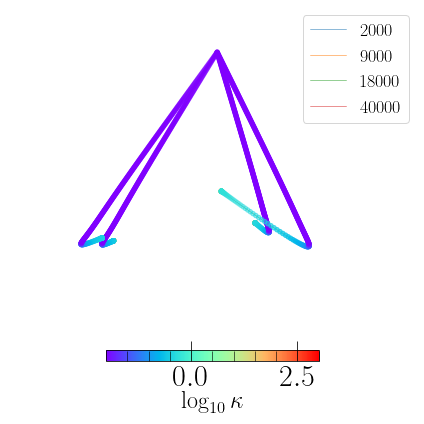

In [62]:
PlotFrenetSerretFrame('Data/TraceHeadOn_0_0_100_500/') #[4, 12237, 20986])

##### Histogram the curvatures

In [17]:
## Plot CDF of Frenet-Serret curvature
def PlotCurvatureCDF(p_arr):
    
    fig = plt.figure(figsize=(10,6))
    
    cs = sns.color_palette('BuGn_r', n_colors=len(p_arr))
    for i, p in enumerate(p_arr):
        ns, kappas = GetFrenetSerretMaxCurvatures(p)
        kappas = np.sort(kappas)
        ns = range(len(kappas))
        ns = ns/np.max(ns)

        plt.plot(ns, kappas, color = cs[i],label = p.split('_')[4].split('/')[0])
        plt.fill_between(ns, 1e-3, kappas, color = cs[i], alpha = 0.1)

    legend = plt.legend(title = 'Geodesic Start Time')
    plt.setp(legend.get_title(),fontsize=20)
    plt.yscale('log')
    plt.ylabel('Max $\kappa$, curvature')
    plt.xlabel('Running Percent of Geodesic Indices')
    plt.ylim(1e-3, 1e5)
    plt.xlim(0.0, 1.0)
    plt.tight_layout()
    plt.show()
    

In [18]:
##PlotCurvatureCDF(['Data/TraceHeadOn_0_0_100_150/', 'Data/TraceHeadOn_0_0_100_319.7_Horizon/', 'Data/TraceHeadOn_0_0_100_500/']) #[4, 12237, 20986])

## Plot geodesics above / below certain curvature thresholds

In [19]:
## Plot geodesic trajectories colored by max curvature
def PlotByMaxCurvature(p):
                
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, y_h, z_h, color='black', lw = 2.0)
    
    Indices, MaxCurvatures = GetFrenetSerretMaxCurvatures(p)
    Indices = Indices[::100]
    MaxCurvatures= MaxCurvatures[::100]
    MaxCurvatures = np.log10(np.array(MaxCurvatures))
   
    Max = np.max(MaxCurvatures)
    Min = 3 #np.min(MaxCurvatures)
    
    ii = np.where((MaxCurvatures < Max) & (MaxCurvatures > Min))[0]
    Indices = Indices[ii]
    print(Indices)
    MaxCurvatures = MaxCurvatures[ii]
    

    cmap = matplotlib.cm.get_cmap('cool')
    colors = [cmap(curv/Max) for curv in MaxCurvatures]
    
    for n, color in zip(Indices, colors):
        t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
        ax.plot(x, y, z, lw = 1.0, color = color)

    ## just for the colorbar
    ss = ax.scatter(x, y, z, s=0, c=x, cmap = cmap, vmin=Min, vmax=Max)
    cbar = fig.colorbar(ss, fraction=0.03, pad=0.04,  orientation="horizontal")
    cbar.set_label(r'$\log_{10}$ max curvature $\kappa$', rotation=0)
    
    lim = 4.0
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    ax.set_axis_off()

    plt.tight_layout()
    plt.show()

In [20]:
#PlotByMaxCurvature('Data/TraceHeadOn_0_0_100_500/') 

## Plot locations of max curvature

In [21]:
## Plot the max curvature location for each geodesic
def PlotMaxCurvatureLocations(p):
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    
    #Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
       #t_h, x_h, y_h, z_h, temp = CutTimesGeodesic(t_h, x_h, y_h, z_h, z_h, 155, 180)
        plt.plot(x_h, y_h, z_h, color='black', lw = 3.0)

    thresh = 3
    
    ns, kappa, x, y, z = GetFrenetSerretMaxCurvatures(p, loc = True)
    kappa = np.log10(kappa)
    ii = np.where((kappa > thresh))[0]
    
    skip = 1
    ns = ns[ii][::skip]
    kappa = kappa[ii][::skip]
    x = x[ii][::skip]
    y = y[ii][::skip]
    z = z[ii][::skip]
    
    ss = ax.scatter(x, y, z, s=5, c=kappa, cmap = 'rainbow', vmin=thresh, vmax=4.25)
    
    cbar = fig.colorbar(ss, fraction=0.03, pad=0.04,  orientation="horizontal")
    cbar.set_label(r'$\log_{10} \kappa$', rotation=0)

    ax.set_xlabel('X',labelpad=10)
    ax.set_ylabel('Y', labelpad=10)
    ax.set_zlabel('Z', labelpad=10)
    
    lim = 2.0
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_axis_off()

    #plt.legend()
    plt.tight_layout()
    plt.show()
    

In [22]:
##PlotMaxCurvatureLocations('Data/TraceHeadOn_0_0_100_500/') 

## Plot lensing refinement method results + final positions

In [23]:
## Plot X, Y camera data and kappas on top of it
def PlotRefinementMethodResult(p, shadow=False):
    
    """ # [1] = Tag
        # [2] = Camera x
        # [3] = Camera y
        # [4] = Camera position z
        # [5] = Surface ID
        # [6] = Extracted direction x
        # [7] = Extracted direction y
        # [8] = Extracted direction z
        # [9] = Extracted redshift
        ** note that everything is off by 1 since there column
           numberings start at 1
    """
    
    
    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    
    tags = data[:,0]
    print(len(tags))
    tags = tags.astype(int)
    x_pos = data[:,1]
    y_pos = data[:,2]
    surface = data[:,4]
    
    tags_fs, kappas = GetFrenetSerretMaxCurvatures(p)
    kappas = np.log10(kappas)
    
    infty = np.where(surface == 7.)[0]
    aha = np.where(surface == 2.)[0]
    ahb = np.where(surface == 3.)[0]
    ahc = np.where(surface == 4.)[0]
    fig = plt.figure(figsize=(10,8))
    
    if shadow:
        
        s = 1
        plt.scatter(x_pos[infty], y_pos[infty], s=s, c='lightblue', label=r'Out to $\infty$')
        plt.scatter(x_pos[aha], y_pos[aha], s=s, c='blue', label=r'Close to AhA')
        plt.scatter(x_pos[ahb], y_pos[ahb], s=s, c='red', label=r'Close to AhB')
        plt.scatter(x_pos[ahc], y_pos[ahc], s=s, c='black', label=r'Close to AhC')
    
    else:
        
        #arr = ahb
        #ss = plt.scatter(x_pos[arr], y_pos[arr], s=20, c=kappas[arr], cmap = 'jet', vmin=3.0, vmax=3.6)
        arr = ahb
        ss = plt.scatter(x_pos, y_pos, s=30, c=kappas, cmap = 'jet', vmin=3, vmax=4.25)
        cbar = fig.colorbar(ss, fraction=0.03, pad=0.04)
        cbar.set_label(r'Max $\log_{10} \kappa$', rotation=-90, labelpad=20)

    
    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    if shadow:
        legend = plt.legend(title='Geodesic Fate', loc='upper left', fontsize=16, framealpha=1.0)
        plt.setp(legend.get_title(),fontsize=16)
    lim = 0.2
    plt.xlim(0.5 - lim, 0.5 + lim)
    plt.ylim(0.5 - lim, 0.5 + lim)
    plt.tight_layout()
    #plt.savefig('Camera.pdf')
    plt.show()
    

In [24]:
##PlotRefinementMethodResult('Data/TraceHeadOn_0_0_100_500/', shadow=False)

In [25]:
## Interpolate a quantity (like the max Frenet-Serret curvature) onto the camera data
def CameraInterpolation(p):

    file = p + 'RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['LensingCore.dat']
    
    tags = data[:,0]
    print(len(tags))
    tags = tags.astype(int)
    x_pos = data[:,1]
    y_pos = data[:,2]
    surface = data[:,4]
    
    tags_fs, kappas = GetFrenetSerretMaxCurvatures(p)
    print(min(kappas), max(kappas))
    kappas = np.log10(kappas)

    fig = plt.figure(figsize=(10,8))
    
    z = np.array(kappas)
    rows = np.array(x_pos) 
    cols = np.array(y_pos) 
    
    ## Number of points to interpolate to
    YY = 1000
    XX = 1000
    ## number of contours
    N_cont = 1000 
    ## Bounds for the colobar
    cmap = 'jet'
    vmin = 3.0
    vmax = 3.6
    lim = 0.2
    ## Bounds for the figure

    
    xi = np.linspace(0.5 - lim, 0.5 + lim, XX)
    yi = np.linspace(0.5 - lim, 0.5 + lim, YY)

    GD = scipy.interpolate.griddata((rows, cols), z.ravel(),
                          (xi[None,:], yi[:,None]), method='cubic')

    CS = plt.contourf(xi,yi,GD,N_cont,cmap = cmap, vmin=vmin, vmax=vmax)

    m = plt.cm.ScalarMappable(cmap=cmap)
    m.set_array(GD)
    m.set_clim(vmin, vmax)
    cbar = plt.colorbar(m, boundaries=np.linspace(vmin, vmax, 6), fraction=0.03, pad=0.01,  orientation="vertical")
    cbar.set_label(r'Max $\log_{10} \kappa$', rotation=-90, labelpad=20)
    
    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.show()

In [26]:
##CameraInterpolation('Data/TraceHeadOn_0_0_100_150/')

## Plot lapse p0

In [27]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def PlotLapsep0(p_arr, figname):
    
    def plot_lapse_file(p, color):
        Indices = GetGeodesicIndices(p)
        Indices = [0, 1]
        for n in Indices:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            t, x, y, z, lapse = CutTimesGeodesic(t, x, y, z, lapse, 150, 190)
            
            dtlapse = np.gradient(lapse, t)
            ddtlapse = np.gradient(dtlapse, t)
            
            plt.plot(t, lapse, lw = 1.0, label = n)
            
    fig = plt.figure(figsize=(12,8))
    
    plt.axvline(160.7, ls = '-', color='black', lw = 0.1)
    plt.axhline(0.0, ls = '-', color='black', lw = 0.1)
    
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_lapse_file(p, cs[i])

    plt.xlabel(r'$t/M$')
    plt.ylabel('Log Lapse $p_0$')
    #plt.ylabel('d/dt Log Lapse $p_0$')
    #plt.ylabel('Log Lapse $p_0$')
    #plt.xlim(150, 170)

    plt.legend()
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    


In [29]:
##PlotLapsep0(['Data/TraceHeadOn_0_0_100_319.7/'],'Winding')

## Plot volume data

In [30]:
## Plot the volume data from ApplyObservers

def GetVolumeData():
    p = '/Users/mokounkova/TracingMerger/Data/HeadOn_Harmonic/JoinedLev2/160.7/'
    X = np.array([])
    Y = np.array([])
    Z = np.array([])
    Data = np.array([])
    for ff in ['Vars_SphereD0.h5', 'Vars_SphereD1.h5']:
        file = p + ff
        f = h5py.File(file, 'r')
        
        x = np.array(f['Coordinates']['Step000000']['x'][:])
        y = np.array(f['Coordinates']['Step000000']['y'][:])
        z = np.array(f['Coordinates']['Step000000']['z'][:])
        data = np.array(f['Psi4']['Step000000']['scalar'][:])
        
        X = np.concatenate((X, x))
        Y = np.concatenate((Y, y))
        Z = np.concatenate((Z, z))
        Data = np.concatenate((Data, data))
    s = 1
    return X[::s], Y[::s], Z[::s], Data[::s]


In [31]:
## Plot the volume data from ApplyObservers

def PlotVolumeData(p):

    def plot_trajectories_file(p):
        Indices = [12237, 11126, 10616, 7766, 20986]
        for n in Indices[::1]:
            t, x, y, z, lapse = GetGeodesicTrajectory(p, n)
            #print(t[1:] - t[:-1])
            t, x, y, z = CutTimesGeodesic(t, x, y, z, 160.7, 161)
            r = sqrt(x**2 + y**2 + z**2)
            #print(r)
            for i in range(len(t)):
                print("Geodesic: ", n, "t: ", t[i], "x: %.4f y: %.4f z: %.4f" % (x[i], y[i], z[i]))
            for tt, xx, yy, zz in zip(t, x, y, z):
                ax.text(xx, yy, zz, str(tt))
            
            t, x, y, z = GetGeodesicTrajectory(p, n)
            #t, x, y, z = CutTimesGeodesic(t, x, y, z, 140, 170)
            ax.plot(x, y, z, lw = 0.5, label = n)

                
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

#     x, y, z, Lapse = GetVolumeData()
#     cb = ax.scatter(x, y, z, c = Lapse, s=10)
#     fig.colorbar(cb)
    
    plot_trajectories_file(p)
        
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    lim = 3.0
#     ax.set_xlim(0.3, 0.5)
#     ax.set_ylim(-2.0, -1.9)
#     ax.set_zlim(0.5, 0.6)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)


    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    R = 2.063450893388303
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="r", linewidth = 0.1)

    
    
    ax.set_axis_off()
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    


In [32]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def CoordPartials(p):
    
    def PlotGradient(t, X, lab):
        dX = np.gradient(X, t)
        ddX = np.gradient(dX, t)
        plt.plot(t, ddX, '-', label = lab, lw = 1.0, markersize=5)
        
    def PlotGradientSum(t, x, y, z, lab):
        dx = np.gradient(x, t)
        ddx = np.gradient(dx, t)
        
        dy = np.gradient(y, t)
        ddy = np.gradient(dy, t)
        
        dz = np.gradient(z, t)
        ddz = np.gradient(dz, t)
        
        plt.plot(t, ddx**2 + ddy**2, ddz**2)
    
    Indices = [12237, 11126, 10616, 7766, 20986]
    
    plt.figure(figsize=(10, 6))

    plt.xlim(110, 250)
    
        
    for n in Indices:
        t, x, y, z = GetGeodesicTrajectory(p, n)
        #PlotGradient(t, z, "Geodesic no. " + str(n))
        PlotGradientSum(t, x, y, z, "Geodesic no. " + str(n))

    plt.axvline(153.81, color='black', lw=1.0)
    plt.axvline(160.7, color='black', lw=1.0)
    
    plt.xlabel('Coordinate time')
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [33]:
##CoordPartials('Data/TraceHeadOn_0_0_100_319.7/')

## Isotropic sphere distribution

In [34]:
def SpherePlot():
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ## Sphere radius
    R = 100
    
    ## Plot mesh sphere
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="blue", linewidth=0.1)
    
    
    ## Camera coordinates
    theta_points = 10
    phi_points = 20
    
    cs = sns.color_palette('husl', n_colors=phi_points)
    for u, i in zip(np.linspace(0, 2*pi, phi_points), range(phi_points)):
        x = []
        y = []
        z = []
        for v in np.linspace(0, pi, theta_points):
            x.append(R*np.cos(u)*np.sin(v))
            y.append(R*np.sin(u)*np.sin(v))
            z.append(R*np.cos(v))
            #print(int(R*np.cos(u)*np.sin(v)), int(R*np.sin(u)*np.sin(v)), int(R*np.cos(v)))
        ax.scatter(x, y, z, s=100, color=cs[i])
            
            
        
    #u, v = np.mgrid[0:2*np.pi:points, 0:np.pi:points]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_axis_off()
    lim = 100
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Sphere.pdf')
    plt.show()

##SpherePlot()

## Paraview file manipulation

In [35]:
## Paraview file manipulation
def GetPVDFiles(p):
    Files = os.listdir(p + '/Data')
    Trim = [file.split('_')[1][:5] for file in Files]
    Num = [trim[0] + trim[2:4] + '.' + trim[-1] for trim in Trim]
    return Files, Num

def WritePVDFile(p):
    """ Write a PVD file for a given set of .vtk files"""
    
    f = open(p + '/Data.pvd', 'w')
    f.write("<VTKFile type=\"Collection\" version=\"0.1\" byte_order=\"LittleEndian\">\n")
    f.write("<Collection>\n")
    
    Files, Num = GetPVDFiles(p)
    for file, num in zip(Files, Num):
        f.write("<DataSet timestep=\"" + num + "\" file=\"Data/"+file+"\" />\n")

    
    f.write("</Collection>\n")
    f.write("</VTKFile>")
    f.close()